# Pipeline
## Cleaning confounds
We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.
## Nested k-fold cross validation
We employed the nested approach to accomandate the hyper-parameter selection and model selection. This is a complex and costly method but the smaple size allows us to use this approach.

In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.utils import load_pkl
from src.file_io import save_output
from src.models import nested_kfold_cv_scca, clean_confound, permutate_scca
from src.visualise import set_text_size, show_results, write_pdf, write_png

/usr/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
dat_path = './data/processed/dict_SCCA_data_prepro_revision1.pkl'
# load data
dataset = load_pkl(dat_path)

dataset.keys()

['FC_BzdokDMN',
 'FC_Yeo7',
 'Yeo7LiberalMask_ROIs',
 'Gender',
 'Age',
 'CognitiveMeasures_labels',
 'IDs',
 'CognitiveMeasures',
 'MRIQ_labels',
 'FC_Yeo17',
 'BzdokDMN_ROIs',
 'Motion_power',
 'FC_Yeo7LiberalMask',
 'Yeo17_ROIs',
 'FC_nodes',
 'Motion_Jenkinson',
 'MRIQ',
 'Yeo7_ROIs']

In [5]:
FC_nodes = dataset['FC_nodes']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [6]:
out_folds = 5
in_folds = 5
n_selected = 4

## confound cleaning in CV loops

Fold 1/5


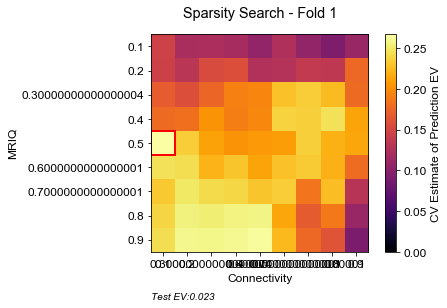


New Best model: 
 4 components,penalty x: 0.1, penalty y: 0.5
OOS performance: 0.0225189064134
Fold 2/5


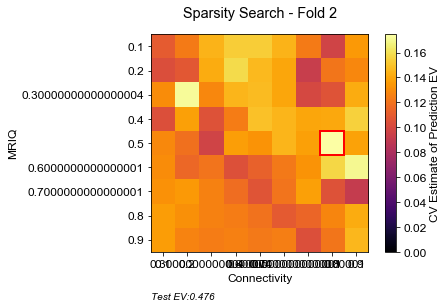


New Best model: 
 4 components,penalty x: 0.8, penalty y: 0.5
OOS performance: 0.475761403841
Fold 3/5


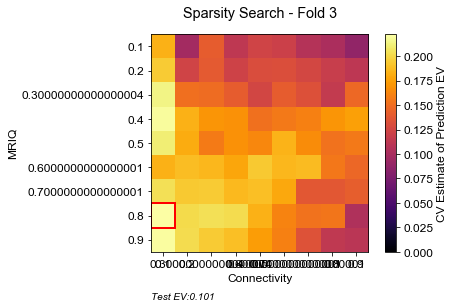

Fold 4/5


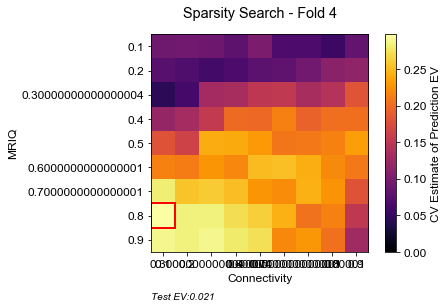

Fold 5/5


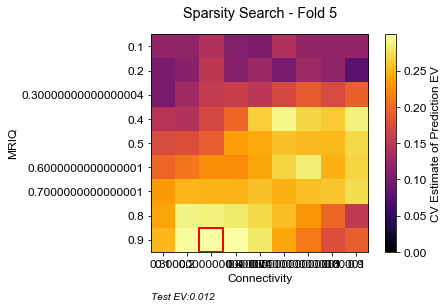


Best parameters based on outer fold ev results: X-0.8; Y-0.5

CPU times: user 28min 46s, sys: 9min 44s, total: 38min 31s
Wall time: 33min 51s


In [7]:
%%time
para_search, best_model, pred_errors = nested_kfold_cv_scca(
    FC_nodes, MRIQ, R=confound_raw, n_selected=n_selected, 
    out_folds=5, in_folds=5, 
    reg_X=(0.1, 0.9), reg_Y=(0.1, 0.9)
)

In [9]:
X, Y, R = clean_confound(FC_nodes, MRIQ, confound_raw)

In [10]:
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import zscore

lr = LinearRegression(fit_intercept=False)
lr.fit(R, np.arctanh(FC_nodes))
rec_ = lr.coef_.dot(R.T).T
r_2 = 1 - (np.var(np.arctanh(FC_nodes) - rec_) / np.var(np.arctanh(FC_nodes)))
print "confounds explained {}% of the FC data".format(np.round(r_2 * 100), 0)

lr = LinearRegression(fit_intercept=False)
lr.fit(R, zscore(MRIQ))
rec_ = lr.coef_.dot(R.T).T
r_2 = 1 - (np.var(zscore(MRIQ) - rec_) / np.var(zscore(MRIQ)))
print "confounds explained {}% of the self-report data".format(np.round(r_2 * 100), 0)

confounds explained 36.0% of the FC data
confounds explained 2.0% of the self-report data


In [11]:
u, v = best_model.u, best_model.v

In [8]:
set_text_size(12)
figs = show_results(u, v, range(1,58), dataset['MRIQ_labels'], rank_v=True, sparse=True)
write_png('./reports/revision/bestModel_yeo7nodes_component_{:}.png', figs)
X_scores, Y_scores, df_z = save_output(dataset, confound_raw, best_model, X, Y, path=None)

df_z.to_csv('./data/processed/NYCQ_CCA_score_revision_yeo7nodes_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_revision_yeo7nodes_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))

joblib.dump(best_model, 
            './models/SCCA_Yeo7nodes_revision_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY))

NameError: name 'X' is not defined

In [12]:
df_permute = permutate_scca(X, Y, best_model.cancorr_, best_model, n_permute=1000)
df_permute

,P-values,alpah0.001,alpah0.01,alpah0.05
Component,,,,
1,0.001,False,True,True
2,0.002,False,True,True
3,0.022,False,False,True
4,0.996,False,False,False
